<a href="https://colab.research.google.com/github/rrizwan98/English_To_French_Translation/blob/main/Eng_to_Fren_Translation_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name='/content/drive/My Drive/english to french.zip'
with ZipFile (file_name,'r')as zip:
  zip.extractall()
  print('raza')

raza


In [ ]:
import os, sys

import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [ ]:
url='/content/eng_-french.csv'
data = pd.read_csv(url, header='infer')
data

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
...,...,...
175616,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
175617,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
175618,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
175619,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...


In [ ]:

english_text = data['English words/sentences']
french_text = data['French words/sentences']

english_text=english_text[:175620]
french_text=french_text[:175620]
french_text=['\t'+text+'\n' for text in french_text]

In [ ]:

import re

input_sequence_english = []
output_sequence_french = []
output_sentences_french_input=[]

for i in range(len(english_text)):
    text = english_text[i].lower()
    text = re.sub('[^a-zA-Z]',' ',text)
    input_sequence_english.append(text)
    
    

for i in range(len(french_text)):
    ftext = french_text[i].lower()
    ftext = (re.sub("[^a-zA-Z' àâäèéêëîïôœùûüÿçÀÂÄÈÉÊËÎÏÔŒÙÛÜŸÇ]",' ',ftext))
    input = ftext + ' <eos>'
    output_input = '<sos> ' + ftext
    output_sequence_french.append(input)
    output_sentences_french_input.append(output_input)
    

In [ ]:
print(len(input_sequence_english))

print(len(output_sequence_french))
print(len(output_sentences_french_input))

print(input_sequence_english[172])
print(output_sequence_french[172])
print(output_sentences_french_input[172])

175620
175620
175620
i m sad 
 je suis triste   <eos>
<sos>  je suis triste  


In [ ]:

#Tokenization
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sequence_english)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sequence_english)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

num_words_input = len(word2idx_inputs) + 1
print(num_words_input)

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 13903
13904
Length of longest sentence in input: 44


In [ ]:
#Tokenization
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sequence_french + output_sentences_french_input)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sequence_french)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_french_input)
output_integer_seq=list(output_integer_seq)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)


Total unique words in the output: 26809
Length of longest sentence in the output: 47


In [ ]:

encoder_input_sequence = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequence.shape)
print("encoder_input_sequences[172]:", encoder_input_sequence[172])
encoder_input_sequence=np.zeros((len(input_sequence_english),max_input_len),dtype=np.float32)

encoder_input_sequences.shape: (175620, 44)
encoder_input_sequences[172]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   1  27 825]


In [ ]:
print(word2idx_inputs['the'])
print(word2idx_inputs["ill"])

4
1037


In [ ]:
decoder_input_sequence = pad_sequences(output_input_integer_seq,maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequence.shape)
print("decoder_input_sequences[172]:", decoder_input_sequence[172])
decoder_input_sequence=np.zeros((len(input_sequence_english),max_out_len),dtype=np.float32)

decoder_input_sequences.shape: (175620, 47)
decoder_input_sequences[172]: [  2   3  24 950   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
decoder_targets_one_hot=pad_sequences(output_input_integer_seq,maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequence.shape)
print("decoder_input_sequences[172]:", decoder_input_sequence[172])
decoder_targets_one_hot=np.zeros((len(encoder_input_sequence),max_out_len),dtype='float32')

decoder_input_sequences.shape: (175620, 47)
decoder_input_sequences[172]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:

print(word2idx_outputs["<sos>"])
print(word2idx_outputs["je"])
print(word2idx_outputs["suis"])
print(word2idx_outputs["malade"])

2
3
24
412


In [ ]:
'''

z=np.zeros(len(input_sequence_english))
b=np.zeros((max_out_len,num_words_input),dtype=np.float32)
#c=np.zeros(,dtype=np.float32)

decoder_targets_one_hot=np.array([z,b],dtype=np.float32)

d=47
e=26810

#z=np.array(z)
#z=len(input_sequence_english)
#a=float(a)
#b=float(num_words_output)
#print(a.dtype)
'''

'\n\nz=np.zeros(len(input_sequence_english))\nb=np.zeros((max_out_len,num_words_input),dtype=np.float32)\n#c=np.zeros(,dtype=np.float32)\n\ndecoder_targets_one_hot=np.array([z,b],dtype=np.float32)\n\nd=47\ne=26810\n\n#z=np.array(z)\n#z=len(input_sequence_english)\n#a=float(a)\n#b=float(num_words_output)\n#print(a.dtype)\n'

In [ ]:
print(z.dtype)
print(type(max_out_len))
print(type(num_words_output))
print(num_words_output)
print(max_out_len)

NameError: ignored

In [ ]:
'''
#decoder_targets_one_hot=[]
#decoder_targets_one_hot.append(np.asarray([z,max_out_len,num_words_output], dtype=np.float32))
#decoder_targets_one_hot=np.array(decoder_targets_one_hot)

decoder_targets_one_hot = np.zeros((
        a,
        d,
        e
        
),dtype='float32')

#decoder_targets_one_hot.astype(dt) 
#np.array(decoder_targets_one_hot, dtype=np.float32)
print(type(decoder_targets_one_hot))
'''

"\n#decoder_targets_one_hot=[]\n#decoder_targets_one_hot.append(np.asarray([z,max_out_len,num_words_output], dtype=np.float32))\n#decoder_targets_one_hot=np.array(decoder_targets_one_hot)\n\ndecoder_targets_one_hot = np.zeros((\n        a,\n        d,\n        e\n        \n),dtype='float32')\n\n#decoder_targets_one_hot.astype(dt) \n#np.array(decoder_targets_one_hot, dtype=np.float32)\nprint(type(decoder_targets_one_hot))\n"

In [ ]:
for i, d in enumerate(decoder_input_sequence):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i,t] = 1

In [ ]:
#Time to bulid the model
latent_dim=256
#inputs for the encoder
encoder_inputs = Input(shape=(None,max_input_len))
#encoder lstm
encod_lstm = (LSTM(latent_dim,return_state = True))
encoder_output,state_h,state_c = encod_lstm(encoder_inputs)

#hidden from encoder to pass to the decoder as initial hidden state
encoder_states = [state_h,state_c]

#inputs for the decoder
decoder_inputs = Input(shape=(None,max_out_len,))
#decoder lstm 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_output,_,_= decoder_lstm(decoder_inputs,initial_state = encoder_states)
#The decoder output is passed through the softmax layer that will learn to classify the correct french character
#Activation functions are used to transform vectors before computing the loss in the training phase
#for more on softmax https://gombru.github.io/2018/05/23/cross_entropy_loss/
dense_layer = Dense(num_words_output, activation='softmax')
decoder_output = dense_layer(decoder_output)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 44)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 47)]   0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 308224      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  311296      input_4[0][0]                    
                                                                 lstm_2[0][1]          

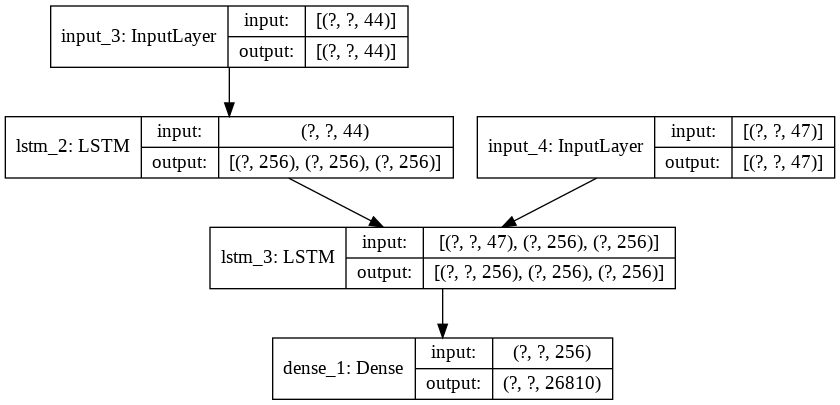

In [ ]:

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True,show_layer_names=True)

In [ ]:
i

175619

In [ ]:
num_words_output
print(len(output_sequence_french))

175620


In [ ]:
print('aaa',encoder_input_sequence.shape)
print('bbb',decoder_input_sequence.shape)
print('ccc',decoder_targets_one_hot.shape)

aaa (175620, 44)
bbb (175620, 47)
ccc (175620, 47)


In [ ]:
r = model.fit(
    [encoder_input_sequence, decoder_input_sequence],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/20


ValueError: ignored